<a href="https://colab.research.google.com/github/mlerma54/RSIGradCAM/blob/main/Copy_of_RSI_Grad_CAM_w_path_selection_PyTorch_w_ResNet50_Ver01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RSI-Grad-CAM (Rieman-Stieltjes Integrated Grad-CAM)**

# PyTorch version

# Model: ResNet50

# Rather than a baseline use an integration path in image space

# Version of the code for public posting


In [1]:
# code version
ver='2023-12-28b'
print('code version:',ver)

code version: 2023-12-28b


In [2]:
import datetime
print('Last run:',datetime.datetime.now())

Last run: 2023-12-29 00:43:01.949903


In [3]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# this is to time execution time
!pip install ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.2 MB/s eta 0:00:00
time: 246 µs (started: 2023-12-29 00:43:24 +00:00)


Root dir

## <font color="red">Please give below paths as per the paths in your system<font>

In [5]:
root = root = '/content/gdrive/My Drive/RSI-Grad-CAM/'
images_dir = root + 'images/'

import os

for d in [root, images_dir]:
  print(d)
  assert(os.path.isdir(d))

/content/gdrive/My Drive/RSI-Grad-CAM/
/content/gdrive/My Drive/RSI-Grad-CAM/images/
time: 1.84 ms (started: 2023-12-29 00:43:24 +00:00)


# **Load packages**

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torchsummary import summary

from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

time: 6.22 s (started: 2023-12-29 00:43:24 +00:00)


In [7]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

time: 54.2 ms (started: 2023-12-29 00:43:31 +00:00)


---

In PyTorch it is hard to dissect pretrained network like the ones from the VGG family, so attribution methods like GradCAM, which need to extract information from internal layers, need to be implemented with a previous knowledge of the structure of the network to which they are going to be applied. So, let's download a ResNet network first and study its structure.

# **Pretrained ResNet50 model**

In [8]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights='ResNet50_Weights.IMAGENET1K_V1')
model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 77.0MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

time: 3.44 s (started: 2023-12-29 00:43:31 +00:00)


In [9]:
#IMAGE_SIZE_1, IMAGE_SIZE_2, IMAGE_SIZE_3 = model.input.shape[1:]
IMAGE_SIZE_1, IMAGE_SIZE_2, IMAGE_SIZE_3 = 3, 224, 224
INPUT_SHAPE = (IMAGE_SIZE_1, IMAGE_SIZE_2, IMAGE_SIZE_3)
IMAG_SIZE = (IMAGE_SIZE_2, IMAGE_SIZE_3)
print(INPUT_SHAPE, IMAG_SIZE)

(3, 224, 224) (224, 224)
time: 725 µs (started: 2023-12-29 00:43:34 +00:00)


In [10]:
summary(model.to(device), INPUT_SHAPE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

The following is needed to understand the structure of the network and how to get to the desired layer.

In [11]:
print([n for n, _ in model.named_children()])

['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']
time: 647 µs (started: 2023-12-29 00:43:36 +00:00)


We are intereted in the submodules called 'layer1', 'layer2', 'layer3', 'layer4'

The layers are sequences of bottlenecks

In [12]:
getattr(model,'layer3')

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Co

time: 3.9 ms (started: 2023-12-29 00:43:36 +00:00)


layer 3 contains 6 bootlenecks (0-5)

In [13]:
print([n for n, _ in model.layer3.named_children()])

['0', '1', '2', '3', '4', '5']
time: 511 µs (started: 2023-12-29 00:43:36 +00:00)


In [14]:
getattr(model,'layer4')

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): 

time: 2.99 ms (started: 2023-12-29 00:43:36 +00:00)


layer4 contains 3 bootlenekcs (0-2)

In [15]:
print([n for n, _ in model.layer4.named_children()])

['0', '1', '2']
time: 486 µs (started: 2023-12-29 00:43:36 +00:00)


We will be interested in the last bootleneck of each layer (although we can also pick any other bootleneck if we wish).

In [16]:
getattr(model,'layer4')[-1]

Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)

time: 2.83 ms (started: 2023-12-29 00:43:36 +00:00)


In [17]:
print([n for n, _ in model.layer4[-1].named_children()])

['conv1', 'bn1', 'conv2', 'bn2', 'conv3', 'bn3', 'relu']
time: 403 µs (started: 2023-12-29 00:43:36 +00:00)


In [18]:
getattr(model.layer4[-1],'conv3')

Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)

time: 2.94 ms (started: 2023-12-29 00:43:36 +00:00)


In [19]:
model.layer4[-1].conv3 # layer 4, bottleneck -1 (2), convolutional layer 3

Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)

time: 2.75 ms (started: 2023-12-29 00:43:36 +00:00)


In [20]:
getattr(getattr(model,'layer4')[-1],'conv3') # this is the last convolutional layer of the network

Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)

time: 2.62 ms (started: 2023-12-29 00:43:36 +00:00)


---

# **Display heatmaps**

In [21]:
#def overlay_heatmap(heatmap,image,alpha=0.5,colormap=cv2.COLORMAP_VIRIDIS):
#def overlay_heatmap(heatmap,image,alpha=0.5,colormap=cv2.COLORMAP_HOT):

def overlay_heatmap(heatmap,image,alpha=0.5,colormap=cv2.COLORMAP_JET): # improved colormap 4/25/2022
  '''
  apply the supplied color map to the heatmap and then
  overlay the heatmap on the input image
  '''

  heatmap = cv2.applyColorMap(heatmap, colormap) # produce colormap
  heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) # convert to RGB
  output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

  # return a 2-tuple of the color mapped heatmap and the output, overlaid image
  return (heatmap, output)

time: 645 µs (started: 2023-12-29 00:43:36 +00:00)


Plotting function

In [22]:
# this function determines if a tensor can be interpreted as a prob. dist. (e.g. output of a softmax)
def is_prob_dist(x):
  return (torch.all(x >= 0) and torch.all(x <= 1) and torch.abs(torch.sum(x.flatten().squeeze()) - 1.0) < 1e-8)

time: 347 µs (started: 2023-12-29 00:43:36 +00:00)


In [23]:
# Read the categories
with open(root + "imagenet_classes.txt", "r") as f:
  categories = [s.strip() for s in f.readlines()]

time: 494 ms (started: 2023-12-29 00:43:36 +00:00)


In [24]:
# preprocess images for us with ResNet50 network

preprocess = transforms.Compose([
      #transforms.Resize(256),
      #transforms.CenterCrop(224),
      transforms.Resize(IMAG_SIZE, antialias=None), # <-
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # <- needed for using ResNet50 trained with ImageNet
])

time: 581 µs (started: 2023-12-29 00:43:36 +00:00)


In [25]:
def display_heatmaps(imag_filename, attr_method_instance, baseline, m_steps=50, top_pred=0):
  '''
  INPUT parameters:
  - image_filename: path to image file. e.g. image_filename = images_dir + 'beagle.jpg'
  - attr_method_instance: attribution method instance, e.g.: attr_method_instance = gcmodel
  - add_softmax: set True if the model lacks a final softmax (otherwise 'probabilities' will actually be logits)
  - top_pred = which class we what to locate starting a the top predicted,
    i.e., 0 = class with the top (highest) score, 1 = second top, etc.
  '''

  input_image = Image.open(imag_filename)
  input_image

  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

  input_batch = input_batch.to(device)
  model.to(device)

  # this should produce the model ouput
  out = attr_method_instance(input_batch)

  # top model predictions
  if is_prob_dist(out[0]):
    probabilities = out[0]
  else:
    probabilities = F.softmax(out[0], dim=0)

  # Show top categories per image
  top5_prob, top5_catid = torch.topk(probabilities, 5)
  for i in range(top5_prob.size(0)):
    print(i, top5_catid[i].item(), categories[top5_catid[i]], top5_prob[i].item())

  print()

  # predicted class
  classIdxPred = out.argmax().item()
  classIdxSel = out[0].argsort(descending=True)[top_pred].item()
  print('predicted, class:', classIdxPred)
  print('selected, class: ', classIdxSel)
  print()

  interpolated_images = interpolate_images(baseline, input_batch, m_steps) # make the integration path here

  heatmap = attr_method_instance.compute_heatmap(interpolated_images, classIdxSel)
  heatmap = cv2.resize(heatmap.detach().cpu().numpy(), (input_image.size[0], input_image.size[1]))

  input_image_np = np.asarray(input_image)
  print(input_image_np.shape)
  print()

  heatmap, output = overlay_heatmap(heatmap,input_image_np)

  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,10))
  ax1.imshow(input_image)
  ax1.axis('off')
  ax2.imshow(heatmap)
  ax2.axis('off')
  ax3.imshow(output)
  ax3.axis('off')

  plt.show()

  print()

time: 1.04 ms (started: 2023-12-29 00:43:36 +00:00)


# **RSI-Grad-CAM**

In [26]:
# the image interpolation has been moved outside RSI-Grad-CAM

def interpolate_images(baseline, image, m_steps):
  '''
  Returns an array of images interpolated between baseline and final image
  '''

  # image should be a 3D or 4D torch tensor with batch and channels first

  im_shape = image.shape
  if len(im_shape) == 4 and im_shape[0] == 1:
    image_sqz = image[0] # remove single batch dimension
  elif len(im_shape) == 3:
    image_sqz = image
    image = torch.unsqueeze(image_sqz, 0)
  else:
    raise ValueError("Input image shape {} is invalid.".format(im_shape))

  if image_sqz.shape != baseline.shape:
    raise ValueError("Input and baseline images have different shapes: {} {}".format(image_sqz.shape,baseline.shape))

  # create the sequence of interpolated images as a single batch
  alphas = torch.linspace(start=0.0, end=1.0, steps=m_steps+1).to(device)
  alphas_x = alphas[:, None, None, None]
  baseline_x = torch.unsqueeze(baseline, axis=0)
  input_x = torch.unsqueeze(image_sqz, axis=0)
  delta = input_x - baseline_x
  images = baseline_x +  alphas_x * delta

  return images

time: 694 µs (started: 2023-12-29 00:43:36 +00:00)


In [27]:
# RSI Grad-CAM in PyTorch - uses layers of a ResNet50

# Rather than baseline and image, input the integration path in image space

class RSI_GradCamModel(nn.Module):

  def __init__(self, model, submodule_name, layer_no, sub_layer_name, add_softmax=False):
    '''
    INPUT parameters
    - model: CNN to which we wish to apply this attribution method
    # the following may change depending on the network structure, these should work for sequential models like the ResNet family
    - submodule_name: e.g. 'layer4'
    - layer_no: e.g.: -1 if we want the last layer of a submodule
    - sublayer_name: e.g.: 'conv3'
    #------------------------------------------------------------
    - add_softmax: set True if the model lacks a final softmax and you want to add it for computing heatmaps
    '''

    super().__init__()
    self.gradients = None
    self.tensorhook = []
    self.layerhook = []
    self.selected_out = None

    self.model = model
    self.submodule_name = submodule_name
    self.layer_no = layer_no
    self.sub_layer_name = sub_layer_name
    self.add_softmax = add_softmax

    # REGISTER THE LAYER WHERE HEATMAPS ARE GOING TO BE GENERATED
    # the submodule is accessed by name, the layer by number, and the sublayer by name
    self.layerhook.append(getattr(getattr(self.model,self.submodule_name)[self.layer_no],self.sub_layer_name).register_forward_hook(self.forward_hook()))

    for p in self.model.parameters():
        p.requires_grad = True

  def activations_hook(self,grad):
    self.gradients = grad

  def get_act_grads(self):
    return self.gradients

  def forward_hook(self):
    def hook(module, inp, out):
      self.selected_out = out
      self.tensorhook.append(out.register_hook(self.activations_hook))
    return hook


  def stieltjes_integral_approximation(self, gradients, convOutputs):
    '''
    Riemann-Stieltjes Integral approximation,
    arguments are integrand and integrator respectively
    '''

    # riemann_trapezoidal (average height of trapezoid)
    grads = (gradients[:-1] + gradients[1:]) / 2.0
    # integrator increments (lenght of trapezoid base)
    incr_convOutputs = convOutputs[1:] - convOutputs[:-1]
    # terms in the Riemann-Stieltjes Integral approximation
    summands = grads * incr_convOutputs
    # add them up
    integrated_gradients = torch.sum(summands, axis=0)
    return integrated_gradients

  def compute_heatmap(self, image_batch, classIdx, eps=1e-8):
    '''
    image_batch: integration path - first image is baseline, last image is the final image
    '''

    image = image_batch[-1:] # final image (as a 4D tensor)
    m_steps = image_batch.shape[0] - 1 # number of interpolation steps

    # forward pass
    self.model.zero_grad()

    # find gradients - loss has to be scalar, this cannot be done in a batch
    grads_list = []
    acts_list = []
    for i in range(m_steps + 1):
      out = self.model(torch.unsqueeze(image_batch[i],0))
      if self.add_softmax:
        out = F.softmax(out,dim=-1)
      acts = self.selected_out
      loss = out[:, classIdx] # loss has to be scalar, this cannot be done in a batch
      loss.backward()
      acts_list.append(acts)
      grads_list.append(F.relu(self.gradients))

    acts_batch = torch.stack(acts_list)
    grads_batch = torch.stack(grads_list)

    integrated_gradients = self.stieltjes_integral_approximation(grads_batch,acts_batch)

    pooled_grads = torch.mean(integrated_gradients, dim=[0,2,3])

    for i in range(acts.shape[1]):
        acts[:,i,:,:] *= pooled_grads[i]


    heatmap_j = torch.mean(acts, dim = 1).squeeze()
    heatmap_j = F.relu(heatmap_j) # final ReLU

    (w, h) = (image.shape[2], image.shape[3])
    resized_heatmap = torchvision.transforms.Resize((w, h), antialias=None)(torch.unsqueeze(heatmap_j,0))[0]
    numer = resized_heatmap - torch.min(resized_heatmap)
    denom = torch.max(resized_heatmap) - torch.min(resized_heatmap) + eps # eps = small epsilon to be added to denominator to avoid division by zero
    heatmap = numer / denom
    heatmap = (heatmap * 255).type(torch.uint8)

    return heatmap # don't forget to move it to the cpu and convert to numpy array after returning: heatmap = heatmap.detach().cpu().numpy()

  def forward(self,x):
    out = self.model(x)
    if self.add_softmax:
      out = F.softmax(out,dim=-1)
    return out

time: 1.89 ms (started: 2023-12-29 00:43:36 +00:00)


In [28]:
baseline = torch.zeros(INPUT_SHAPE)
baseline_img = transforms.ToPILImage()(baseline)
baseline = preprocess(baseline_img).to(device)

time: 20.4 ms (started: 2023-12-29 00:43:36 +00:00)


In [29]:
rsi_gcmodel = RSI_GradCamModel(model,'layer4',-1,'conv3', add_softmax=True).to(device)

time: 5.25 ms (started: 2023-12-29 00:43:36 +00:00)


0 714 pick 1.0
1 693 paddle 5.118842849594074e-12
2 417 balloon 2.5182698808190462e-12
3 767 rubber eraser 2.1093573936148413e-12
4 679 necklace 2.0270599435101566e-12

predicted, class: 714
selected, class:  714

(432, 432, 3)



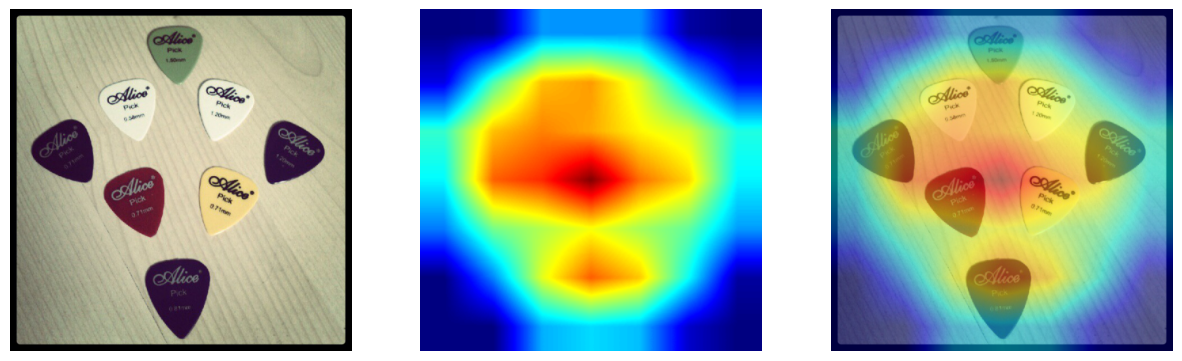


time: 3.31 s (started: 2023-12-29 00:43:36 +00:00)


In [30]:
image_filename = images_dir + 'pick.jpg'
display_heatmaps(image_filename, rsi_gcmodel, baseline)

---

In [31]:
rsi_gcmodel3 = RSI_GradCamModel(model,'layer3',-1,'conv3', add_softmax=True).to(device)

time: 5.65 ms (started: 2023-12-29 00:43:40 +00:00)


0 714 pick 1.0
1 693 paddle 5.118842849594074e-12
2 417 balloon 2.5182698808190462e-12
3 767 rubber eraser 2.1093573936148413e-12
4 679 necklace 2.0270599435101566e-12

predicted, class: 714
selected, class:  714

(432, 432, 3)



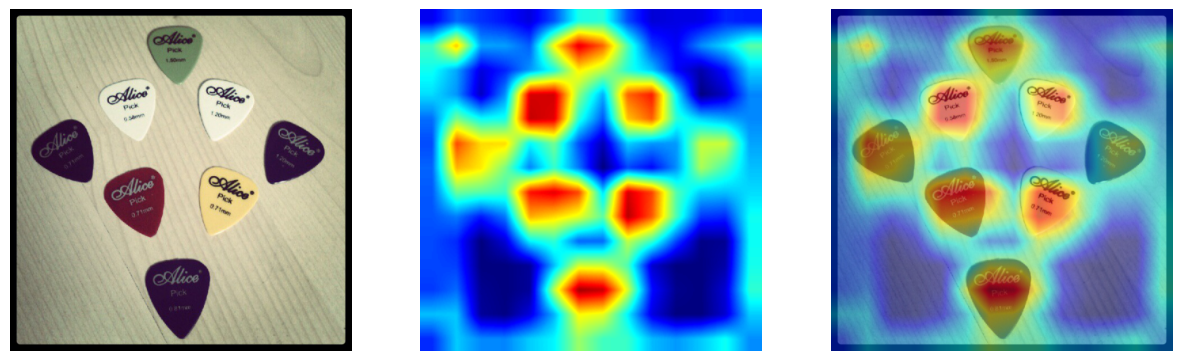


time: 1.4 s (started: 2023-12-29 00:43:40 +00:00)


In [32]:
image_filename = images_dir + 'pick.jpg'
display_heatmaps(image_filename, rsi_gcmodel3, baseline)